Name : Hanish Sai Rohit
ph no: 8332082623
email id: hanishsidhu@gmail.com
email id: hanishrohit@gmail.com

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1>  Business Problem </h1>

<h2>  Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1> Machine Learning Probelm </h1>

<h2> Data </h2>

<h3> Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> Mapping the real world problem to an ML problem </h2>

<h3> Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> Performance Metric </h3>

Metrics: 
* log-loss
* Binary Confusion Matrix

<h2> Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of  80:20. </p>

# Data Acquisition

In [51]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
from sklearn.linear_model import LogisticRegression
import pickle as pk
from datetime import datetime
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import text

In [2]:
if os.path.isfile('train-2.csv'):
    train = pd.read_csv('train-2.csv')
    print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
None


In [11]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Data Analysis & Data Cleaning

## checking duplicates

In [15]:
no_duplicated_data = train.drop_duplicates(subset=['question1','question2'], keep='first', inplace=False)
print("Number of similiar data points : ",train.shape[0]-no_duplicated_data.shape[0])

Number of similiar data points :  0


## checking if any data point has same question1 and question2

In [17]:
count =0
for i in range(0,train.shape[0]):
    if train['question1'].iloc[i] == train['question2'].iloc[i]:
        count = count +1
print(" Number of data points with the same 'question1' and 'question2' :", count)

 Number of data points with the same 'question1' and 'question2' : 0


<h3> Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

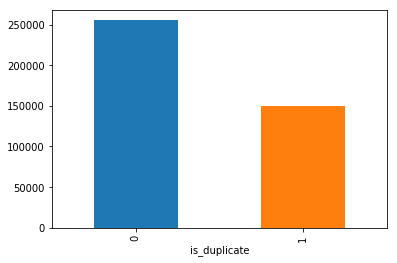

In [27]:
train.groupby("is_duplicate")['id'].count().plot.bar()

observation:
    * it's a slightly imbalanced data.

In [30]:
print('~> Total number of question pairs for training:  {}'.format(len(train)))
print('\n~> Question pairs are not Similar (is_duplicate = 0): {}%'.format(100 - round(train['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):  {}%'.format(round(train['is_duplicate'].mean()*100, 2)))

~> Total number of question pairs for training:  404290

~> Question pairs are not Similar (is_duplicate = 0): 63.08%

~> Question pairs are Similar (is_duplicate = 1):  36.92%


<h3>  Number of unique questions </h3>

In [31]:
qids = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



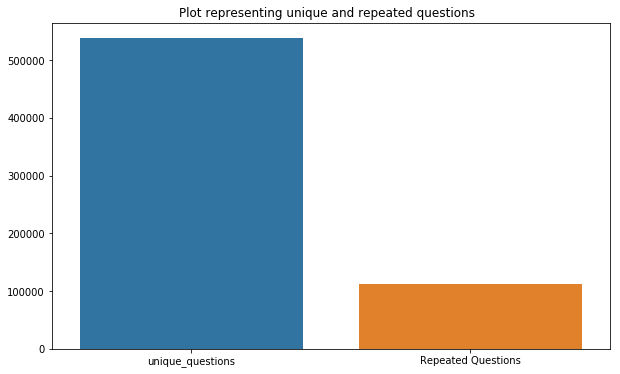

In [32]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

observation:
    * most of the questions are unique.

<h3> Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



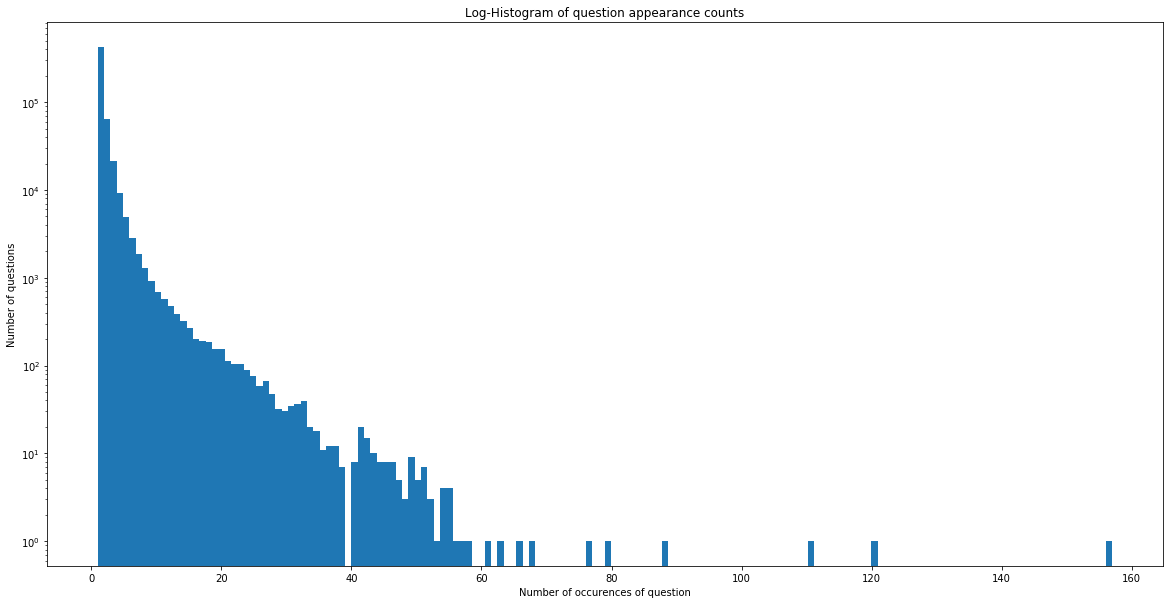

In [33]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> Checking for NULL values </h3>

In [37]:
#Checking whether there are any rows with null values
nan_rows = train[train.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [39]:
train = train.fillna('')

## Extracting basic features

In [3]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    train = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    train['freq_qid1'] = train.groupby('qid1')['qid1'].transform('count') 
    train['freq_qid2'] = train.groupby('qid2')['qid2'].transform('count')
    train['q1len'] = train['question1'].str.len() 
    train['q2len'] = train['question2'].str.len()
    train['q1_n_words'] = train['question1'].apply(lambda row: len(row.split(" ")))
    train['q2_n_words'] = train['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    train['word_Common'] = train.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    train['word_Total'] = train.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    train['word_share'] = train.apply(normalized_word_share, axis=1)

    train['freq_q1+q2'] = train['freq_qid1']+train['freq_qid2']
    train['freq_q1-q2'] = abs(train['freq_qid1']-train['freq_qid2'])

    train.to_csv("df_fe_without_preprocessing_train.csv", index=False)
train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0


<h3> Analysis of the extracted features </h3>

In [43]:
print ("Minimum length of the questions in question1 : " , min(train['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(train['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", train[train['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", train[train['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> Feature: word_share </h4>

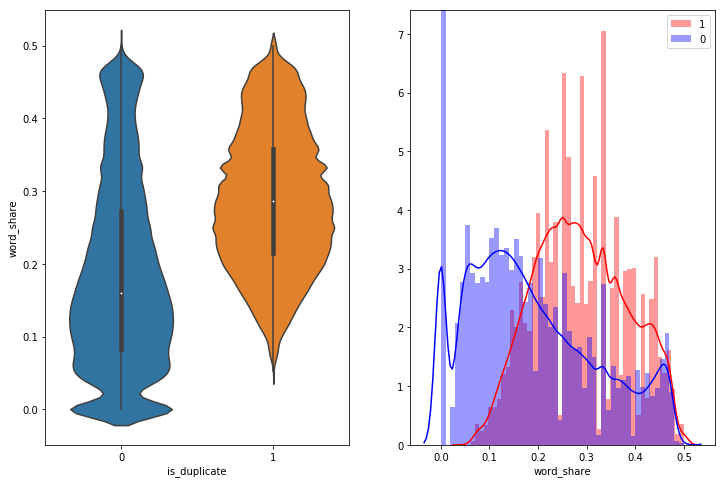

In [44]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = train[0:])

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> Feature: word_Common </h4>

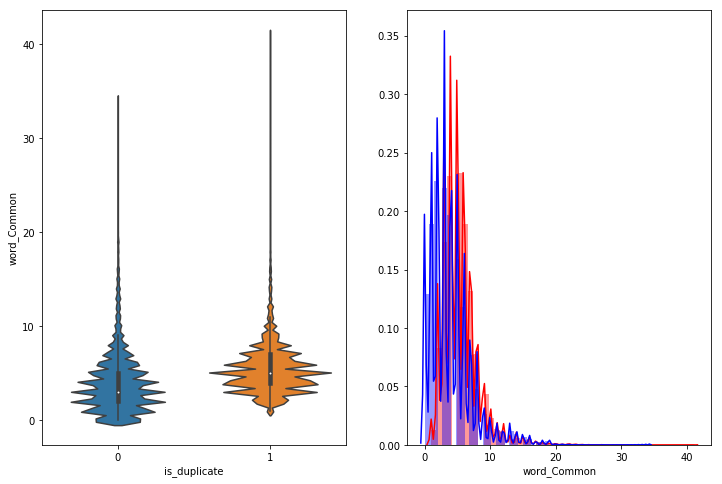

In [46]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = train[0:])

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

obsevation:
    * word_share is comparatively important feature than word_feature

### Analysing the duplicate question's text

In [4]:
train_duplicates = train[train['is_duplicate']==1]
train_not_duplicates = train[train['is_duplicate']==0]

In [5]:
index =[]
for row in range(0,train_duplicates.shape[0]):
    common = train_duplicates['word_Common'].iloc[row]
    q1= train_duplicates['q1_n_words'].iloc[row]
    q2= train_duplicates['q2_n_words'].iloc[row]
    if q1 - common < 2 or q2 - common < 2:
        if q1 - common != 0 or q2 - common != 0 :
            if (len(index) < 5):
                index.append(row)
            else:
                break

In [16]:

x = PrettyTable()
x.title = 'Duplicate questions with more number of common words'
x.field_names =['question1','question2']


for row in index:   
    x.add_row([train_duplicates['question1'].iloc[row],train_duplicates['question2'].iloc[row]])
print(x)

+-------------------------------------------------------------------------------------------+
|                    Duplicate questions with more number of common words                   |
+----------------------------------------------+--------------------------------------------+
|                  question1                   |                 question2                  |
+----------------------------------------------+--------------------------------------------+
|     What can make Physics easy to learn?     |  How can you make physics easy to learn?   |
| What was your first sexual experience like?  |   What was your first sexual experience?   |
|         What does manipulation mean?         |       What does manipulation means?        |
| What is a narcissistic personality disorder? | What is narcissistic personality disorder? |
|      How I can speak English fluently?       | How can I learn to speak English fluently? |
+----------------------------------------------+------------

observation:
    * most of the uncommon words are stop words

### Analysing the non-duplicate question's text

In [19]:
index =[]
for row in range(0,train_not_duplicates.shape[0]):
    common = train_not_duplicates['word_Common'].iloc[row]
    q1= train_not_duplicates['q1_n_words'].iloc[row]
    q2= train_not_duplicates['q2_n_words'].iloc[row]
    if q1 - common < 2 or q2 - common < 2:
        if q1 - common != 0 or q2 - common != 0 :
            if (len(index) < 5):
                index.append(row)
            else:
                break
x = PrettyTable()
x.title = 'Non-Duplicate questions with more number of common words'
x.field_names =['question1','question2']


for row in index[1:-1]:   
    x.add_row([train_not_duplicates['question1'].iloc[row],train_not_duplicates['question2'].iloc[row]])
print(x)

+---------------------------------------------------------------------------------------+
|                Non-Duplicate questions with more number of common words               |
+-------------------------------------------+-------------------------------------------+
|                 question1                 |                 question2                 |
+-------------------------------------------+-------------------------------------------+
|          What is web application?         |   What is the web application framework?  |
|   What is best way to make money online?  | What is best way to ask for money online? |
| What is the best travel website in spain? |      What is the best travel website?     |
+-------------------------------------------+-------------------------------------------+


observation:
    * most of the uncommon words are nouns, proper adjectives

### Removing symbols in the data

In [6]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def remove_symbols(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)


    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()  
    return x



In [7]:
question1 = list(train['question1'])
question2 = list(train['question2'])

In [8]:
from tqdm import tqdm
question1_without_symbols =[]
for q in tqdm(question1):
    h = remove_symbols(q) 
    question1_without_symbols.append(h)

question2_without_symbols =[]

for q in tqdm(question2):
    h = remove_symbols(q) 
    question2_without_symbols.append(h)

100%|██████████| 404290/404290 [05:32<00:00, 1217.35it/s]


In [9]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [52]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.99998,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759


# <h3> Analysis of extracted features </h3>

<h4>  Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [13]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


__ Word Clouds generated from  duplicate pair question's text __

In [27]:
duplicated_qns = train[train['is_duplicate']==1]
non_duplicated_qns = train[train['is_duplicate']==0]

In [11]:
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")

In [38]:
all_duplicated_qns = np.dstack([duplicated_qns['question1'],duplicated_qns['question2']]).flatten()

Word Cloud for Duplicate Question pairs


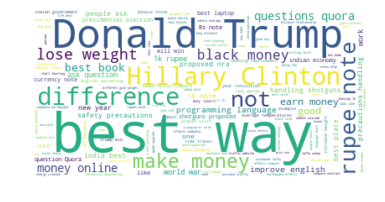

In [55]:
from wordcloud import WordCloud

wc = WordCloud(background_color="white",max_words=len(all_duplicated_qns) ,stopwords=stopwords,relative_scaling =1)
wc.generate(str(list(all_duplicated_qns)))
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [45]:
all_non_duplicated_qns = np.dstack([non_duplicated_qns['question1'],non_duplicated_qns['question2']]).flatten()

Word Cloud for Non Duplicate Question pairs


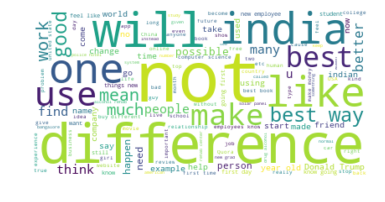

In [56]:
from wordcloud import WordCloud

wc = WordCloud(background_color="white", stopwords=stopwords,relative_scaling =1)
wc.generate(str(list(all_non_duplicated_qns)))
print ("Word Cloud for Non Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

observation:
    * few words occur frequently

## <h4>Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

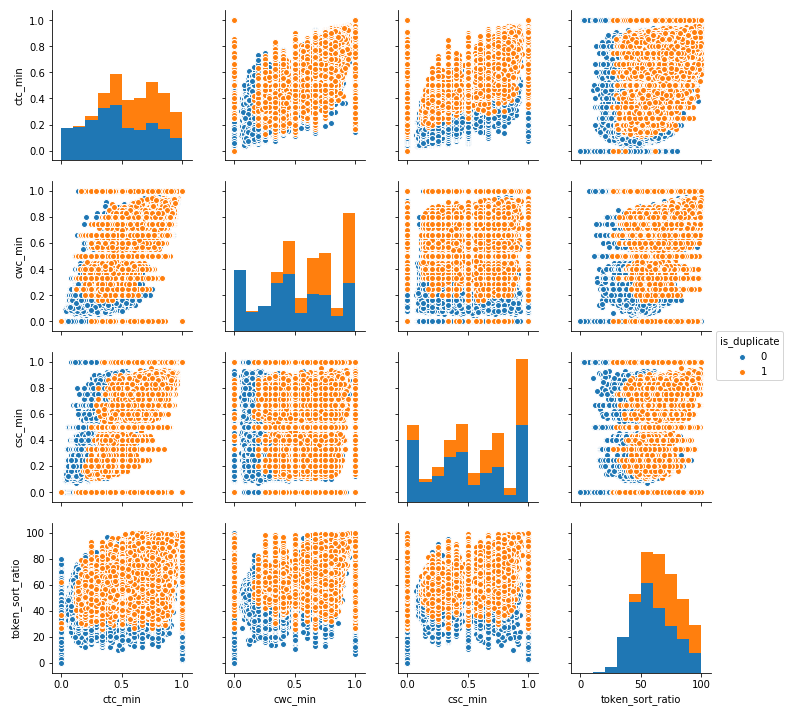

In [57]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

observation:
    * all the feature seems useful as the data is partialy seperable in almost all paitplots 

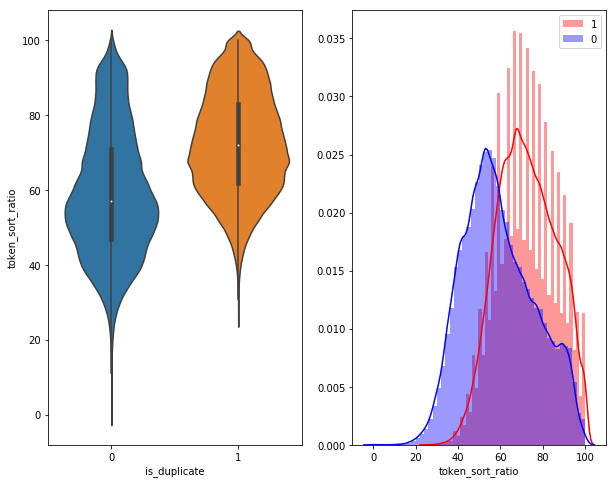

In [60]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

observation:
    * duplicate questions tend to have lesser token sort ratio.
    * non-duplicate questions tend to have larger token sort ratio.

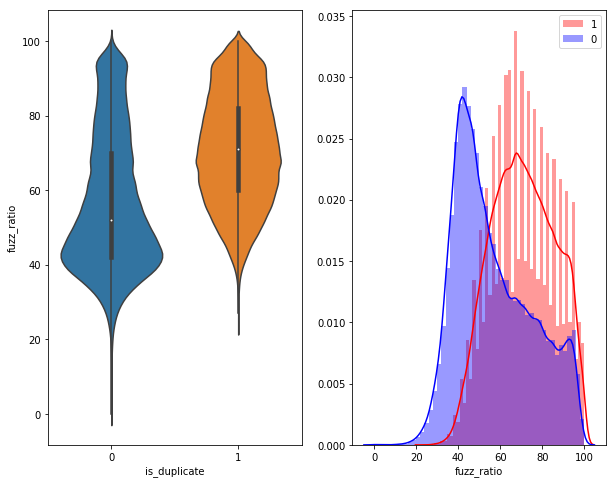

In [61]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

observation:
    * duplicate questions tend to have lesser fuzz ratio.
    * non-duplicate questions tend to have larger fuzz ratio.

# Data visualization

In [53]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [72]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 0.443s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.235s
[t-SNE] Iteration 50: error = 80.8968964, gradient norm = 0.0430571 (50 iterations in 8.832s)
[t-SNE] Iteration 100: error = 70.3833160, gradient norm = 0.0099593 (50 iterations in 7.692s)
[t-SNE] Iteration 150: error = 68.6159134, gradient norm = 0.0056708 (50 iterations in 7.577s)
[t-SNE] Iteration 200: error = 67.7694321, gradient norm = 0.0040581 (50 iterations in 7.548s)
[t-SNE] Iteration 250: error = 67.2746048, gradient norm = 0.0033067

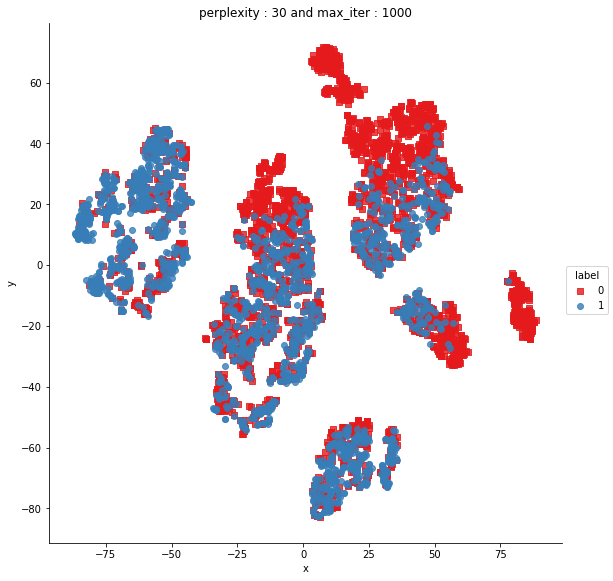

In [73]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

#draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [54]:
from sklearn.manifold import TSNE

tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.017s...
[t-SNE] Computed neighbors for 5000 samples in 0.466s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.240s
[t-SNE] Iteration 50: error = 80.3592682, gradient norm = 0.0335202 (50 iterations in 15.736s)
[t-SNE] Iteration 100: error = 69.1112671, gradient norm = 0.0036575 (50 iterations in 8.584s)
[t-SNE] Iteration 150: error = 67.6171112, gradient norm = 0.0017708 (50 iterations in 8.323s)
[t-SNE] Iteration 200: error = 67.0565109, gradient norm = 0.0011567 (50 iterations in 8.767s)
[t-SNE] Iteration 250: error = 66.7296524, gradient norm = 0.000916

observation:
    * we can observe few datapoints of same class being clustered together. Hence these fuzzywuzzy features plays an important role in classifying the datapoints.

# Data  Preprocessing

In [12]:
from tqdm import tqdm
stop = stopwords
sno = PorterStemmer()

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
cleaned_question1_again=[]
s=''
for sent in tqdm(question1_without_symbols):
    filtered_sentence=[]
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    cleaned_question1_again.append(str1)
    i+=1

i=0
str1=' '
cleaned_question2_again=[]
s=''
for sent in tqdm(question2_without_symbols):
    filtered_sentence=[]
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)  
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    cleaned_question2_again.append(str1)
    i+=1

100%|██████████| 404290/404290 [01:28<00:00, 4575.56it/s]


In [13]:
cleaned_question1_again_df = pd.DataFrame(cleaned_question1_again,columns=['CleanedText_q1'],index=train.index)

In [14]:
cleaned_question2_again_df = pd.DataFrame(cleaned_question2_again,columns=['CleanedText_q2'],index=train.index)

In [15]:
features = pd.concat([df,train,cleaned_question1_again_df,cleaned_question2_again_df],axis = 1)

In [16]:
#https://stackoverflow.com/questions/14984119/python-pandas-remove-duplicate-columns
features = features.loc[:,~features.columns.duplicated()]

In [17]:
features = features.fillna('')

In [80]:
from tqdm import tqdm

dissimilar_words_for_question =[]
for row in tqdm(range(0,features.shape[0])):
    q1 = features['question1'][row].split()
    q2 = features['question2'][row].split()
    dissimilar_words_1 = [x for x in q1 if x not in q2]
    dissimilar_words_2 = [x for x in q2 if x not in q1]
    if(len(dissimilar_words_1)==0):
        dissimilar_words =" ".join(dissimilar_words_2)
    if(len(dissimilar_words_2)==0):
        dissimilar_words =" ".join(dissimilar_words_1)
    if (len(dissimilar_words_1)!=0 and len(dissimilar_words_2)!=0):
        dissimilar_words = dissimilar_words_1 + dissimilar_words_2
        dissimilar_words = set(dissimilar_words)
        dissimilar_words =" ".join(dissimilar_words)
    dissimilar_words_for_question.append(dissimilar_words)

100%|██████████| 404290/404290 [00:18<00:00, 21461.37it/s]


In [82]:

dissimilar_words_for_cleaned_question =[]
for row in tqdm(range(0,features.shape[0])):
    q1 = features['CleanedText_q1'][row].split()
    q2 = features['CleanedText_q2'][row].split()
    dissimilar_words_1 = [x for x in q1 if x not in q2]
    dissimilar_words_2 = [x for x in q2 if x not in q1]
    if(len(dissimilar_words_1)==0):
        dissimilar_words =b" ".join(dissimilar_words_2)
    if(len(dissimilar_words_2)==0):
        dissimilar_words =b" ".join(dissimilar_words_1)
    if (len(dissimilar_words_1)!=0 and len(dissimilar_words_2)!=0):
        dissimilar_words = dissimilar_words_1 + dissimilar_words_2
        dissimilar_words = set(dissimilar_words)
        dissimilar_words =b" ".join(dissimilar_words)
    dissimilar_words_for_cleaned_question.append(dissimilar_words)

100%|██████████| 404290/404290 [00:16<00:00, 24645.60it/s]


In [83]:
features_final = pd.concat([features,pd.DataFrame(dissimilar_words_for_question,columns=["dissimilar_words_for_question"]) \
                            , pd.DataFrame(dissimilar_words_for_cleaned_question,columns=["dissimilar_words_for_cleaned_question"])],axis=1)

In [84]:
features_final.to_csv("features_final.csv")

# Featurization

In [20]:
features_final = pd.read_csv("features_final.csv")

In [21]:
features_final.head(1)

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,...,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,CleanedText_q1,CleanedText_q2,dissimilar_words_for_question,dissimilar_words_for_cleaned_question
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.99998,0.833319,0.999983,...,12,10.0,23.0,0.434783,2,0,b'step step guid invest share market india',b'step step guid invest share market',india,b'india'


In [4]:

tfidf_glove_instance = text.TfidfVectorizer(lowercase=False,)
tfidf_glove_instance.fit_transform(features_final['dissimilar_words_for_cleaned_question'])

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf_glove_instance.get_feature_names(), tfidf_glove_instance.idf_))

In [5]:
#https://github.com/explosion/spaCy/issues/1721
import spacy
nlp = spacy.load('en')

In [6]:
vecs1 = []
for qu1 in tqdm(list(features_final['dissimilar_words_for_cleaned_question'])):
    qu1 = qu1[2:-1]
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
            
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
        
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

100%|██████████| 404290/404290 [1:21:40<00:00, 82.97it/s]


In [7]:
features_final['glove_feat'] = list(vecs1)

In [22]:
from sklearn.model_selection import train_test_split

train_features,test_features = train_test_split(features_final,train_size=0.8,test_size=0.2)

In [23]:
train_score = train_features['is_duplicate']
test_score = test_features['is_duplicate']

In [24]:
train_features = train_features.drop(["is_duplicate"],axis =1)
test_features = test_features.drop(["is_duplicate"],axis =1)

In [11]:
train_features.head(1)

,Unnamed: 0,id,qid1,qid2,question1,question2,cwc_min,cwc_max,csc_min,csc_max,...,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,CleanedText_q1,CleanedText_q2,dissimilar_words_for_question,dissimilar_words_for_cleaned_question,glove_feat
381910,381910,381910,13650,23718,is time travel possible in next 5 years,will time travel be possible in the next 10 ye...,0.833319,0.833319,0.499975,0.249994,...,6.0,18.0,0.333333,49,5,b'time travel possibl next year',b'will time travel possibl next year',be the 10 5 will is,b'will',"[-3.7353649139404297, 6.49038553237915, 2.4906..."


In [12]:
train_glove_features = train_features['glove_feat'].values
test_glove_features = test_features['glove_feat'].values

In [25]:
from sklearn.feature_extraction import text

tfidf_instance = text.TfidfVectorizer(ngram_range=(1,1))

train_features_tfidf = tfidf_instance.fit_transform(train_features['dissimilar_words_for_cleaned_question'].values.astype(str))
test_features_tfidf = tfidf_instance.transform(test_features['dissimilar_words_for_cleaned_question'].values.astype(str))

In [26]:
unique_words = tfidf_instance.get_feature_names()
idf_values = tfidf_instance.idf_
word_idf_df = pd.concat([pd.DataFrame(unique_words,columns =['word']),pd.DataFrame(idf_values,columns=['idf'])],axis =1)
sorted_word_idf_df = word_idf_df.sort_values(by=['idf'])

In [27]:
sorted_word_idf_df = sorted_word_idf_df.reset_index()

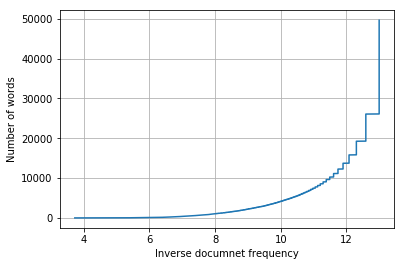

In [28]:
plt.plot(sorted_word_idf_df['idf'],sorted_word_idf_df.index)
plt.ylabel("Number of words")
plt.xlabel("Inverse documnet frequency")
plt.grid()
plt.show()

observation:
    * almost half number of words occurred very rare in the dataset.

In [16]:
train_features = train_features.drop(['Unnamed: 0','CleanedText_q1','CleanedText_q2','id','qid1','qid2','question1','question2','dissimilar_words_for_question','dissimilar_words_for_cleaned_question','glove_feat'],axis =1)
test_features = test_features.drop(['Unnamed: 0','CleanedText_q1','CleanedText_q2','id','qid1','qid2','question1','question2','dissimilar_words_for_question','dissimilar_words_for_cleaned_question','glove_feat'],axis =1)

In [17]:
train_features.head(1)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
165137,0.99995,0.399992,0.0,0.0,0.333328,0.199998,1.0,0.0,4.0,8.0,...,2,29,50,6,10,2.0,16.0,0.125,4,0


In [18]:
train_features = np.array(train_features)
test_features = np.array(test_features)

In [17]:
train_glove_features_list = train_glove_features.tolist()

In [18]:
test_glove_features_list = test_glove_features.tolist()

In [19]:
for row in train_glove_features_list:
    row = row.tolist()

In [20]:
for row in test_glove_features_list:
    row = row.tolist()

In [21]:
train_glove_features_numpy = np.array(train_glove_features_list)
test_glove_features_numpy = np.array(test_glove_features_list)

In [22]:
from scipy.sparse import hstack

train_features_glove_final = np.hstack((train_features,train_glove_features_numpy))
test_features_glove_final = np.hstack((test_features,test_glove_features_numpy))

In [23]:
from sklearn.preprocessing import scale

train_features_glove_final = scale(train_features_glove_final,with_mean=False)
test_features_glove_final = scale(test_features_glove_final,with_mean=False)

In [21]:
from scipy.sparse import hstack

train_features_tfidf = hstack((train_features,train_features_tfidf))
test_features_tfidf = hstack((test_features,test_features_tfidf))

In [23]:
from sklearn.preprocessing import scale

train_features_tfidf = scale(train_features_tfidf,with_mean=False)
test_features_tfidf = scale(test_features_tfidf,with_mean=False)

In [26]:
import pickle as pk

with open('quora_objs.pkl', 'wb') as f: 
    pk.dump([train_score,test_score,train_features_glove_final, test_features_glove_final, train_features,test_features,train_features_tfidf,test_features_tfidf], f)

In [27]:
import pickle as pk

with open('quora_objs_copy.pkl', 'wb') as f: 
    pk.dump([train_score,test_score,train_features_glove_final, test_features_glove_final, train_features,test_features,train_features_tfidf,test_features_tfidf], f)

# Modeling

In [27]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
  
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Applying Logestic Regression for TF-IDF Representation.

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [10**-4,10**-3,10**-2,10**-1,1,10**1]}]

model = GridSearchCV(LogisticRegression(max_iter=1000,solver='lbfgs'), tuned_parameters, scoring = 'neg_log_loss', cv=4,n_jobs=-1,return_train_score=True)
model.fit(train_features,train_score)

print(model.best_estimator_)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


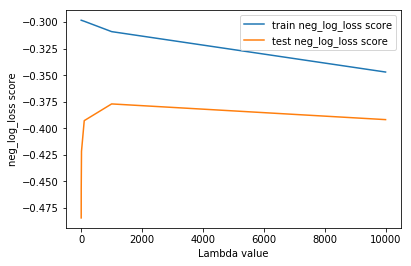

In [35]:
cv_scores = pd.DataFrame(model.cv_results_)
cv_scores = cv_scores.sort_values(by =['param_C'])

plt.plot(1/cv_scores['param_C'],cv_scores['mean_train_score'],label='train neg_log_loss score')
plt.plot(1/cv_scores['param_C'],cv_scores['mean_test_score'],label='test neg_log_loss score')

plt.xlabel('Lambda value')
plt.ylabel('neg_log_loss score')
plt.legend()
plt.show()

In [53]:
y_prob = model.best_estimator_.predict_proba(test_features)
y_prob = y_prob.transpose()
predict_y = y_prob[1] 

score = log_loss(test_score,predict_y)
print("test log loss",score)

test log loss 0.3648848509555236


Total number of data points : 80858


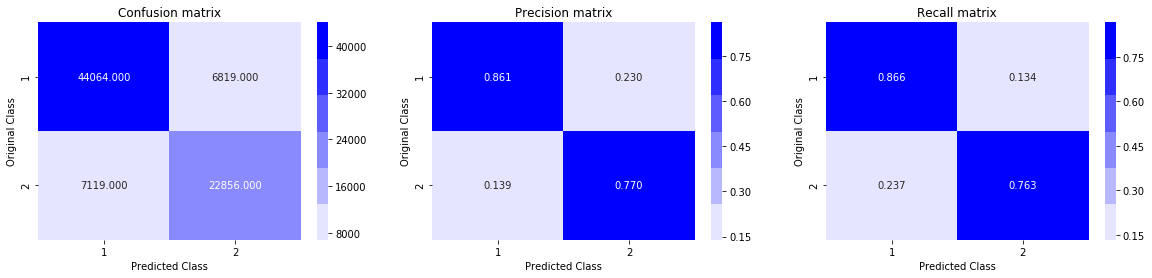

In [54]:
from sklearn.metrics import confusion_matrix

predicted_y =np.argmax(y_prob.T,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(test_score, predicted_y)

--------------------roc curve--------------------


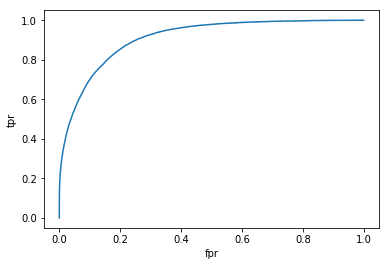

In [61]:
from sklearn.metrics import roc_curve

fpr , tpr , thresholds = roc_curve(test_score, y_prob[1])
print("--------------------roc curve--------------------")
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

## Applying Logestic Regression for TF-IDF weighted GLOVE Representation.

In [67]:
train_features_glove_final_no_nan = np.nan_to_num(train_features_glove_final)
test_features_glove_final_no_nan = np.nan_to_num(test_features_glove_final)

In [68]:
tuned_parameters = [{'C': [10**-4,10**-3,10**-2,10**-1,1,10**1]}]

model = GridSearchCV(LogisticRegression(max_iter=1000,solver='lbfgs'), tuned_parameters, scoring = 'neg_log_loss', cv=4,n_jobs=-1,return_train_score=True)
model.fit(train_features_glove_final_no_nan,train_score)

print(model.best_estimator_)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


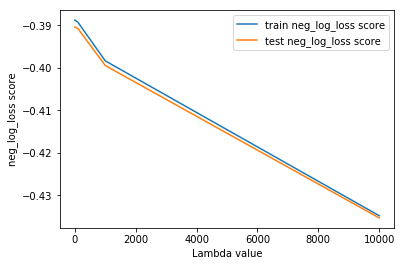

In [69]:
cv_scores = pd.DataFrame(model.cv_results_)
cv_scores = cv_scores.sort_values(by =['param_C'])

plt.plot(1/cv_scores['param_C'],cv_scores['mean_train_score'],label='train neg_log_loss score')
plt.plot(1/cv_scores['param_C'],cv_scores['mean_test_score'],label='test neg_log_loss score')

plt.xlabel('Lambda value')
plt.ylabel('neg_log_loss score')
plt.legend()
plt.show()

Train log loss : 0.389
Test log loss : 0.391
Total number of Test data points : 80858


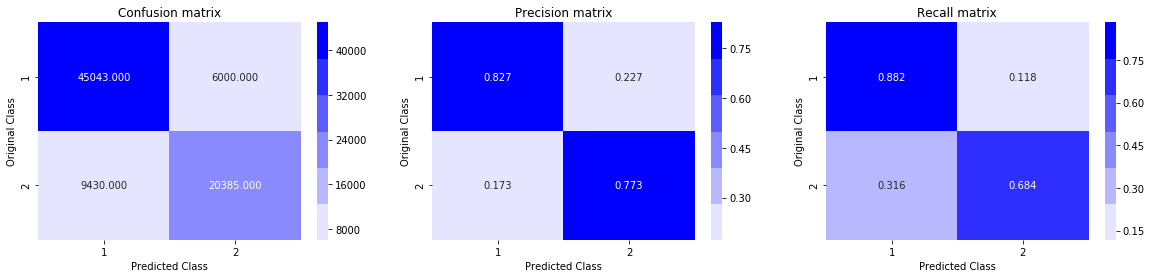

--------------------roc curve--------------------


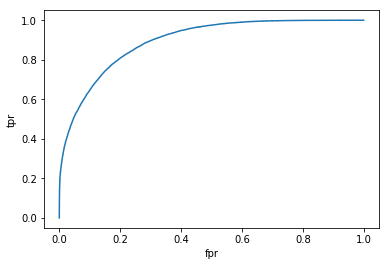

In [79]:
from sklearn.metrics import log_loss

y_prob = model.best_estimator_.predict_proba(train_features_glove_final_no_nan)
y_prob = y_prob.transpose()
predict_y = y_prob[1] 

score = log_loss(train_score,predict_y)
print("Train log loss :",np.round(score,decimals=4))

y_prob = model.best_estimator_.predict_proba(test_features_glove_final_no_nan)
y_prob = y_prob.transpose()
predict_y = y_prob[1] 

score = log_loss(test_score,predict_y)
print("Test log loss :",np.round(score,decimals=4))


from sklearn.metrics import confusion_matrix

predicted_y =np.argmax(y_prob.T,axis=1)
print("Total number of Test data points :", len(predicted_y))
plot_confusion_matrix(test_score, predicted_y)

from sklearn.metrics import roc_curve

fpr , tpr , thresholds = roc_curve(test_score, y_prob[1])
print("--------------------roc curve--------------------")
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

## Applying XG BOOST for TF-IDF weighted GLOVE Representation.

In [1]:
with open('quora_objs.pkl','rb') as f:
    train_score,test_score,train_features_glove_final, test_features_glove_final, train_features,test_features,train_features_tfidf,test_features_tfidf = pk.load(f)

In [4]:
train_features_glove_final_no_nan = np.nan_to_num(train_features_glove_final)
test_features_glove_final_no_nan = np.nan_to_num(test_features_glove_final)

In [6]:

start = datetime.now()
tuned_parameters={
    'max_depth' : [2,3,4],
    'n_estimators': [25,55,75],
    'learning_rate':[1,0.1],
    'colsample_bytree':[0.25,0.5,1],
    'colsample_bylevel':[0.5,1],
    'reg_alpha':[1,10],
    'objective':['binary:logistic'],
    'eval_metric':['logloss'],
    'booster':['gbtree'],
    
}

xgb_model = xgb.XGBClassifier()

model = GridSearchCV(xgb_model, tuned_parameters, scoring = 'neg_log_loss', cv=3,n_jobs=-1,return_train_score=True)
model.fit(train_features_glove_final_no_nan,train_score)

print(model.best_estimator_)
print("Time taken to train :",datetime.now() - start)

/home/hanishsidhu/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='logloss', gamma=0, learning_rate=1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=75, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=10,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
Time taken to train : 2:29:01.410957


In [18]:
cv_scores = pd.DataFrame(model.cv_results_)

In [21]:
cv_scores_best_models = cv_scores.sort_values(by=['rank_test_score'],axis=0)

In [42]:
print(" Top 5 BEST estimators ")
cv_scores_best_models[['mean_score_time','mean_test_score','mean_train_score','param_n_estimators','param_max_depth','param_learning_rate','param_colsample_bylevel','param_colsample_bytree','param_reg_alpha']].head(5)

 Top 5 BEST estimators 


,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,param_max_depth,param_learning_rate,param_colsample_bylevel,param_colsample_bytree,param_reg_alpha
191,1.300309,-0.340046,-0.321079,75,3,1,1,1,10
190,1.380963,-0.341347,-0.320462,75,3,1,1,1,1
195,1.250852,-0.341570,-0.309138,55,4,1,1,1,10
155,1.299649,-0.341869,-0.323273,75,3,1,1,0.5,10
189,1.282317,-0.342011,-0.328131,55,3,1,1,1,10


In [46]:
print(" 5 WORST estimators ")
cv_scores_best_models = cv_scores.sort_values(by=['rank_test_score'],axis=0,ascending=False)
cv_scores_best_models[['mean_score_time','mean_test_score','mean_train_score','param_n_estimators','param_max_depth','param_learning_rate','param_colsample_bylevel','param_colsample_bytree','param_reg_alpha']].head(5)

 5 WORST estimators 


,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,param_max_depth,param_learning_rate,param_colsample_bylevel,param_colsample_bytree,param_reg_alpha
122,1.273173,NaN,NaN,55,4,1,1,0.25,1
124,1.387473,NaN,NaN,75,4,1,1,0.25,1
120,1.076203,-inf,-inf,25,4,1,1,0.25,1
19,1.001440,-0.460614,-0.460319,25,2,0.1,0.5,0.25,10
18,0.973360,-0.460408,-0.460172,25,2,0.1,0.5,0.25,1


Train log loss : 0.3254
Test log loss : 0.3477
Total number of Test data points : 80858


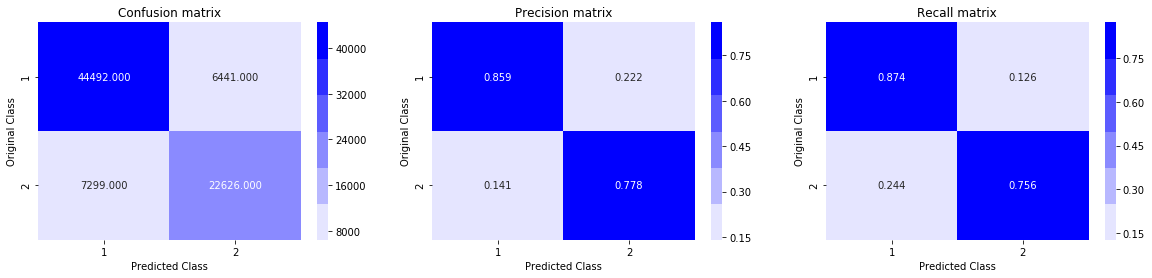

--------------------roc curve--------------------


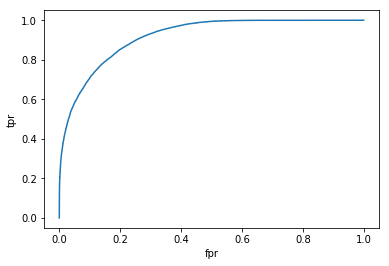

In [47]:
y_prob = model.best_estimator_.predict_proba(train_features_glove_final_no_nan)
y_prob = y_prob.transpose()
predict_y = y_prob[1] 

score = log_loss(train_score,predict_y)
print("Train log loss :",np.round(score,decimals=4))

y_prob = model.best_estimator_.predict_proba(test_features_glove_final_no_nan)
y_prob = y_prob.transpose()
predict_y = y_prob[1] 

score = log_loss(test_score,predict_y)
print("Test log loss :",np.round(score,decimals=4))


predicted_y =np.argmax(y_prob.T,axis=1)
print("Total number of Test data points :", len(predicted_y))
plot_confusion_matrix(test_score, predicted_y)


fpr , tpr , thresholds = roc_curve(test_score, y_prob[1])
print("--------------------roc curve--------------------")
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

In [51]:
cv_scores.to_csv("XGBOOST_CV_SCORES.csv")

# Conclusion

In [46]:
x = PrettyTable()
x.field_names = ["Vectorizer",'Model',"Hyper-Parameters","log loss"]
x.add_row(['Tfidf\n','Logistic Regression','C = 0.001','0.364'])
x.add_row(['Tfidf weighted GLOVE\n\n','Logistic Regression ','C = 0.1','0.391'])
x.add_row(['Tfidf weighted GLOVE\n','XG BOOST','n_estimators =75\n max_depth=3 \n learning rate =1\ncolsample_bylevel =1\ncolsample_bytree =1\nreg_alpha=10\n','0.347'])
print(x)

+----------------------+----------------------+----------------------+----------+
|      Vectorizer      |        Model         |   Hyper-Parameters   | log loss |
+----------------------+----------------------+----------------------+----------+
|        Tfidf         | Logistic Regression  |      C = 0.001       |  0.364   |
|                      |                      |                      |          |
| Tfidf weighted GLOVE | Logistic Regression  |       C = 0.1        |  0.391   |
|                      |                      |                      |          |
|                      |                      |                      |          |
| Tfidf weighted GLOVE |       XG BOOST       |   n_estimators =75   |  0.347   |
|                      |                      |     max_depth=3      |          |
|                      |                      |   learning rate =1   |          |
|                      |                      | colsample_bylevel =1 |          |
|               

# Procedure

* It was clear that the main objective for this bussiness problem was to predict if the questions are similar or not.

* Since the train.csv file was small, I had loaded the data without using Sqlite  

* Cleaned data and basic data analysis on the csv file.

* Basic featurization like calculating number of common words, number of common stop words, etc. in the quesions

* Analysed the basic features.

* Analysed duplicate question's text and non-duplicate question's text.

* Extracted and analysed Fuzzywuzzy features.

* visualised the Fuzzywuzzy features using T-SNE

* Cleaned and preprocessed the text data of the questions.

* As the dissimilar words of two questions decides whether those questions are duplicate or not, I had vectorized only the dissimilar words of the two questions by using TF-IDF vectorizer and TF-IDF weighted GLOVE representation.

* Two main reasons of vectorizing only dissimilar words of the two questions are:
   
   - this will decrease overall dimensions of a tf-idf vector representation, as the corpus size of dissimilar words is less when compared with the text of two questions.
   
   - this will also help the model to understand only the dissimilar words of two questions are causing a datapoint to be duplicate, which is very important as nearly 80% of questions in the dataset are unique.

* As most of the dissimilar words were less frequent in the dataset, I had used Tf-idf vector representation over count vector representation(Bag of Words) for featurizing the dissimilar words.

* Applied logistic regression, As it performs very well with large set of features and also with large number of datapoints

* I had not applied Linear-SVC, as the fit time complexity is more than quadratic with the number of datapoints

* Applied XG Boost on TF-IDF Weighted GLOVE representation, which performed very well than logistic regression 

* Compared all the models using pretty table.

-----------------------------------------THE END------------------------------------------